In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn 
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import * 

import warnings
warnings.filterwarnings("ignore")

In [91]:
def RUL_metric(y_valid, y_pred, threshold=10):

    error = y_valid.reshape(-1) - y_pred.reshape(-1)
    per = np.where(error<=threshold, 1, 0)
    
    return sum(per) / len(per)


In [64]:
path = "data/Battery_RUL.csv"

In [65]:
data = pd.read_csv(path)

In [66]:
data.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [67]:
data.shape

(15064, 9)

In [68]:
# 다음 컬럼들은 RUL에 관계가 없기 때문에 제거한다.
data=data.drop(['Cycle_Index','Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Time constant current (s)','Charging time (s)'],axis=1)

In [69]:
data.head()

,Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),RUL
0,3.670,3.211,5460.001,1112
1,4.246,3.220,5508.992,1111
2,4.249,3.224,5508.993,1110
3,4.250,3.225,5502.016,1109
4,4.290,3.398,5480.992,1107


## Modeling and Predections

In [70]:
class Pipeline:
    def __init__(self, scalar):
        self.scalar = scalar
    
    def fit(self, X, y):
        X = self.scalar.fit_transform(X)
        return X, y.to_numpy(dtype=np.float32)
    
    def transform(self, X, y):
        X = self.scalar.transform(X)
        return X, y.to_numpy(dtype=np.float32)

In [71]:
data = data[data['RUL']!=0]

X = data.drop(['RUL'], axis=1)
y = data['RUL']

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle =False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, shuffle =False)
    

In [73]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
pipeline = Pipeline(scaler)

In [74]:
X_train_s, y_train_s = pipeline.fit(X_train, y_train)
X_val_s, y_val_s = pipeline.transform(X_val, y_val)
X_test_s, y_test_s = pipeline.transform(X_test, y_test)

In [75]:
from torch.utils.data import Dataset, DataLoader

In [76]:
class BatteryDataSet(Dataset):

    def __init__(self, X,y):
        # Data loading
        # self.x = torch.from_numpy(dataset[:, :-1])
        # self.y = torch.from_numpy(dataset[:, [-1]])
        # self.n_samples = self.x.shape[0]
        self.x = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(-1)
        self.n_samples = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        # len(Dataset)
        return self.n_samples

In [77]:
train_dataset = BatteryDataSet(X_train_s, y_train_s)
valid_dataset = BatteryDataSet(X_val_s, y_val_s)
test_dataset = BatteryDataSet(X_test_s, y_test_s)

In [78]:
train_indices = list(range(len(train_dataset)))
valid_indices = list(range(len(valid_dataset)))
test_indices = list(range(len(test_dataset)))

In [79]:
from torch.utils.data.sampler import SubsetRandomSampler

In [80]:
batch_size = 32

In [81]:
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

# set valid dataset ot samplers and loader
valid_sampler = SubsetRandomSampler(valid_indices)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)


# set test dataset ot samplers and loader
test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)


In [82]:
X_train_s.shape, y_train_s.shape

((10535, 3), (10535,))

In [83]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [84]:
input_size = X_train_s.shape[1] #num of columns
hidden_size = 16
num_classes = 1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


In [85]:
from tqdm import tqdm

In [86]:
min_diff_dict = {}

In [87]:
train_loss_list = []

def train_loop(epoch, train_loader, model, loss_fn, optimizer):
    size = len(train_loader)
    train_loss = 0
    with tqdm(train_loader) as pbar :
        for idx, (inputs, y) in enumerate(pbar):
            # Forward path
            outputs = model(inputs)           # ([32, 6])
            loss = loss_fn(outputs, y)

            # Backwards path
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss' : f"{loss.item()/batch_size}"})

    train_loss /= size
    print('===> Epoch [{}] : loss : {:.5}'.format(epoch,  train_loss))
    train_loss_list.append(train_loss)

In [96]:
test_loss_list = []

def val_loop(epoch, dataloader, model, loss_fn):
    size = len(dataloader)
    test_loss = 0

    targets_list = []
    pred_list = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # # Target vs prediction
            pred_np = pred.squeeze().tolist()
            target_np = y.squeeze().tolist()

            try:
                for i,j in zip(pred_np,target_np):
                    pred_list.append(i)
                    targets_list.append(j)
            except:
                pass

    # Average loss
    test_loss /= size
    test_loss_list.append(test_loss)
    scheduler.step(test_loss)
    
    # pred = pred.detach().cpu().numpy()
    # y = y_val_s.detach().cpu().numpy()
    targets_list = np.array(targets_list)
    pred_list = np.array(pred_list)
    RMSE = mean_squared_error(targets_list, pred_list, squared=False)
    MAE = mean_absolute_error(targets_list, pred_list)
    MAPE = mean_absolute_percentage_error(targets_list, pred_list)
    R2 = r2_score(targets_list, pred_list)
    RUL_score = RUL_metric(targets_list, pred_list, threshold=100)
    msg = f"Test: \n Avg loss: {test_loss:>8f}, \n"
    print(msg) 
    msg = f"- RMSE: {(RMSE):>0.2f}, - MAE: {(MAE):>0.2f}, - MAPE: {(MAPE):>0.2f},  - R2: {(R2):>0.2f},  - RUL_metric: {(RUL_score):>0.2f}, \n"
    print(msg)
    print('---'*20)
    


In [97]:
epochs = 100

In [98]:

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_loop(epoch, train_loader, model, criterion, optimizer)
    val_loop(epoch, valid_loader, model, criterion)


print("Fertig!")


Epoch 1
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 519.01it/s, loss=147.05752563476562]


===> Epoch [0] : loss : 1.0019e+04
Test: 
 Avg loss: 18345.717415, 

- RMSE: 135.47, - MAE: 102.58, - MAPE: 1.07,  - R2: 0.84,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 2
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 573.70it/s, loss=385.4039611816406] 


===> Epoch [1] : loss : 8931.4
Test: 
 Avg loss: 20787.106039, 

- RMSE: 144.19, - MAE: 116.73, - MAPE: 1.33,  - R2: 0.82,  - RUL_metric: 0.63, 

------------------------------------------------------------
Epoch 3
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 545.98it/s, loss=1995.032470703125] 


===> Epoch [2] : loss : 8884.4
Test: 
 Avg loss: 20510.665212, 

- RMSE: 143.20, - MAE: 110.01, - MAPE: 1.19,  - R2: 0.82,  - RUL_metric: 0.62, 

------------------------------------------------------------
Epoch 4
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 535.59it/s, loss=309.0531921386719] 


===> Epoch [3] : loss : 9092.5
Test: 
 Avg loss: 19845.060875, 

- RMSE: 140.89, - MAE: 105.00, - MAPE: 1.19,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 5
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 576.36it/s, loss=128.99154663085938]


===> Epoch [4] : loss : 8885.9
Test: 
 Avg loss: 20883.368155, 

- RMSE: 144.49, - MAE: 105.07, - MAPE: 1.13,  - R2: 0.82,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 6
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 554.58it/s, loss=29.98634910583496] 


===> Epoch [5] : loss : 8960.5
Test: 
 Avg loss: 23249.689782, 

- RMSE: 152.51, - MAE: 111.40, - MAPE: 1.41,  - R2: 0.80,  - RUL_metric: 0.71, 

------------------------------------------------------------
Epoch 7
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 570.39it/s, loss=1081.6590576171875]


===> Epoch [6] : loss : 8561.8
Test: 
 Avg loss: 19893.752964, 

- RMSE: 141.08, - MAE: 96.65, - MAPE: 1.14,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 8
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 577.48it/s, loss=134.46641540527344]


===> Epoch [7] : loss : 8219.6
Test: 
 Avg loss: 19821.613229, 

- RMSE: 140.81, - MAE: 100.60, - MAPE: 1.16,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 9
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 522.64it/s, loss=179.31748962402344]


===> Epoch [8] : loss : 8151.8
Test: 
 Avg loss: 19359.767924, 

- RMSE: 139.14, - MAE: 99.11, - MAPE: 1.13,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 10
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 574.81it/s, loss=90.23491668701172] 


===> Epoch [9] : loss : 8128.5
Test: 
 Avg loss: 19422.074456, 

- RMSE: 139.37, - MAE: 99.83, - MAPE: 1.10,  - R2: 0.83,  - RUL_metric: 0.65, 

------------------------------------------------------------
Epoch 11
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 576.35it/s, loss=237.3551483154297] 


===> Epoch [10] : loss : 8125.2
Test: 
 Avg loss: 19155.117028, 

- RMSE: 138.42, - MAE: 99.48, - MAPE: 1.15,  - R2: 0.83,  - RUL_metric: 0.67, 

------------------------------------------------------------
Epoch 12
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 582.33it/s, loss=31.027515411376953]


===> Epoch [11] : loss : 8095.3
Test: 
 Avg loss: 18508.397331, 

- RMSE: 135.88, - MAE: 95.77, - MAPE: 1.10,  - R2: 0.84,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 13
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 553.21it/s, loss=187.9547576904297] 


===> Epoch [12] : loss : 8032.1
Test: 
 Avg loss: 18895.843413, 

- RMSE: 137.49, - MAE: 98.41, - MAPE: 1.11,  - R2: 0.84,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 14
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 561.50it/s, loss=181.35057067871094]


===> Epoch [13] : loss : 8015.2
Test: 
 Avg loss: 18976.600150, 

- RMSE: 137.59, - MAE: 98.66, - MAPE: 1.12,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 15
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 500.35it/s, loss=77.1610107421875]  


===> Epoch [14] : loss : 8005.8
Test: 
 Avg loss: 18886.758923, 

- RMSE: 137.46, - MAE: 98.45, - MAPE: 1.11,  - R2: 0.84,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 16
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 579.64it/s, loss=113.56096649169922]


===> Epoch [15] : loss : 8005.3
Test: 
 Avg loss: 19071.947940, 

- RMSE: 138.02, - MAE: 99.25, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 17
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 565.04it/s, loss=74.611328125]      


===> Epoch [16] : loss : 8001.3
Test: 
 Avg loss: 18908.493289, 

- RMSE: 137.54, - MAE: 98.48, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 18
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 541.21it/s, loss=64.36985778808594] 


===> Epoch [17] : loss : 7992.0
Test: 
 Avg loss: 18918.832105, 

- RMSE: 137.55, - MAE: 98.52, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 19
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 583.30it/s, loss=346.3094177246094] 


===> Epoch [18] : loss : 8012.6
Test: 
 Avg loss: 18911.584092, 

- RMSE: 137.55, - MAE: 98.54, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 20
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 577.03it/s, loss=42.641780853271484]


===> Epoch [19] : loss : 7988.3
Test: 
 Avg loss: 18907.342047, 

- RMSE: 137.54, - MAE: 98.53, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 21
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 585.33it/s, loss=158.89126586914062]


===> Epoch [20] : loss : 7996.9
Test: 
 Avg loss: 18968.194383, 

- RMSE: 137.54, - MAE: 98.53, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 22
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 559.77it/s, loss=253.0676727294922] 


===> Epoch [21] : loss : 8003.4
Test: 
 Avg loss: 18914.083505, 

- RMSE: 137.55, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 23
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 562.82it/s, loss=35.34864044189453] 


===> Epoch [22] : loss : 7986.7
Test: 
 Avg loss: 18908.360632, 

- RMSE: 137.55, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 24
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 578.18it/s, loss=301.0169372558594] 


===> Epoch [23] : loss : 8005.4
Test: 
 Avg loss: 18912.576885, 

- RMSE: 137.54, - MAE: 98.55, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 25
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 575.43it/s, loss=60.3326416015625]  


===> Epoch [24] : loss : 7987.2
Test: 
 Avg loss: 18913.038799, 

- RMSE: 137.54, - MAE: 98.55, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 26
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 481.89it/s, loss=561.8521728515625] 


===> Epoch [25] : loss : 8025.2
Test: 
 Avg loss: 18911.458773, 

- RMSE: 137.54, - MAE: 98.55, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 27
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 575.51it/s, loss=212.14393615722656]


===> Epoch [26] : loss : 7998.7
Test: 
 Avg loss: 18919.742166, 

- RMSE: 137.54, - MAE: 98.55, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 28
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 539.67it/s, loss=1595.2742919921875]


===> Epoch [27] : loss : 8103.4
Test: 
 Avg loss: 18965.464567, 

- RMSE: 137.54, - MAE: 98.55, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 29
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 577.27it/s, loss=199.8851318359375] 


===> Epoch [28] : loss : 7997.6
Test: 
 Avg loss: 18908.250951, 

- RMSE: 137.54, - MAE: 98.55, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 30
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 545.03it/s, loss=1557.6844482421875]


===> Epoch [29] : loss : 8100.4
Test: 
 Avg loss: 18910.454616, 

- RMSE: 137.54, - MAE: 98.55, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 31
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 570.44it/s, loss=106.76006317138672]


===> Epoch [30] : loss : 7990.5
Test: 
 Avg loss: 18903.027702, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 32
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 548.40it/s, loss=119.19617462158203]


===> Epoch [31] : loss : 7991.5
Test: 
 Avg loss: 18967.494586, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 33
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 557.10it/s, loss=69.53356170654297] 


===> Epoch [32] : loss : 7987.7
Test: 
 Avg loss: 18915.350741, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 34
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 548.78it/s, loss=169.82237243652344]


===> Epoch [33] : loss : 7995.3
Test: 
 Avg loss: 18912.113147, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 35
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 570.45it/s, loss=376.66522216796875]


===> Epoch [34] : loss : 8010.9
Test: 
 Avg loss: 18909.460678, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 36
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 572.67it/s, loss=115.6163330078125] 


===> Epoch [35] : loss : 7991.2
Test: 
 Avg loss: 18908.523727, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 37
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 541.46it/s, loss=229.31912231445312]


===> Epoch [36] : loss : 7999.8
Test: 
 Avg loss: 18909.074530, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 38
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 487.66it/s, loss=275.32379150390625]


===> Epoch [37] : loss : 8003.3
Test: 
 Avg loss: 18912.512026, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 39
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 576.07it/s, loss=51.3983268737793]  


===> Epoch [38] : loss : 7986.3
Test: 
 Avg loss: 18916.976701, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 40
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 575.85it/s, loss=33.83852005004883] 


===> Epoch [39] : loss : 7985.0
Test: 
 Avg loss: 18930.694059, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 41
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 578.14it/s, loss=79.08917999267578] 


===> Epoch [40] : loss : 7988.4
Test: 
 Avg loss: 18909.554139, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 42
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 524.42it/s, loss=225.13546752929688]


===> Epoch [41] : loss : 7999.5
Test: 
 Avg loss: 18909.162805, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 43
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 569.91it/s, loss=103.75529479980469]


===> Epoch [42] : loss : 7990.3
Test: 
 Avg loss: 18925.386468, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 44
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 576.36it/s, loss=158.05966186523438]


===> Epoch [43] : loss : 7994.4
Test: 
 Avg loss: 18962.106661, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 45
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 576.35it/s, loss=223.2713623046875] 


===> Epoch [44] : loss : 7999.3
Test: 
 Avg loss: 18908.271329, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 46
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 550.49it/s, loss=42.39182662963867] 


===> Epoch [45] : loss : 7985.6
Test: 
 Avg loss: 18912.121293, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 47
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 576.91it/s, loss=89.05546569824219] 


===> Epoch [46] : loss : 7989.2
Test: 
 Avg loss: 18907.055465, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 48
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 547.70it/s, loss=222.24954223632812]


===> Epoch [47] : loss : 7999.2
Test: 
 Avg loss: 18910.743467, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 49
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 570.39it/s, loss=286.1554260253906] 


===> Epoch [48] : loss : 8004.1
Test: 
 Avg loss: 18907.095301, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 50
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 476.90it/s, loss=31.033565521240234]


===> Epoch [49] : loss : 7984.8
Test: 
 Avg loss: 18914.945896, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 51
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 575.77it/s, loss=85.41252899169922] 


===> Epoch [50] : loss : 7988.9
Test: 
 Avg loss: 18910.083077, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 52
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 565.29it/s, loss=2012.7537841796875]


===> Epoch [51] : loss : 8134.9
Test: 
 Avg loss: 18914.220768, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 53
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 568.42it/s, loss=2102.452880859375] 


===> Epoch [52] : loss : 8141.7
Test: 
 Avg loss: 18908.031859, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 54
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 558.98it/s, loss=214.57704162597656]


===> Epoch [53] : loss : 7998.7
Test: 
 Avg loss: 18967.828332, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 55
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 569.91it/s, loss=125.7148208618164] 


===> Epoch [54] : loss : 7991.9
Test: 
 Avg loss: 18906.685949, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 56
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 573.97it/s, loss=194.69715881347656]


===> Epoch [55] : loss : 7997.2
Test: 
 Avg loss: 18929.299230, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 57
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 569.91it/s, loss=75.2783432006836]  


===> Epoch [56] : loss : 7988.1
Test: 
 Avg loss: 18980.112767, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 58
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 534.65it/s, loss=269.5872802734375] 


===> Epoch [57] : loss : 8002.8
Test: 
 Avg loss: 18905.921827, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 59
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 546.55it/s, loss=43.775001525878906]


===> Epoch [58] : loss : 7985.7
Test: 
 Avg loss: 18954.914006, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 60
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 564.55it/s, loss=90.69737243652344] 


===> Epoch [59] : loss : 7989.3
Test: 
 Avg loss: 18915.469666, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 61
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 576.20it/s, loss=59.44379806518555] 


===> Epoch [60] : loss : 7986.9
Test: 
 Avg loss: 18911.567750, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 62
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 497.75it/s, loss=158.93533325195312]


===> Epoch [61] : loss : 7994.4
Test: 
 Avg loss: 18909.468219, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 63
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 515.23it/s, loss=392.7990417480469] 


===> Epoch [62] : loss : 8012.2
Test: 
 Avg loss: 18917.594761, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 64
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 567.74it/s, loss=55.5471305847168]  


===> Epoch [63] : loss : 7986.6
Test: 
 Avg loss: 18914.121560, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 65
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 568.93it/s, loss=90.18804168701172] 


===> Epoch [64] : loss : 7989.2
Test: 
 Avg loss: 18910.979803, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 66
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 571.01it/s, loss=639.5570068359375] 


===> Epoch [65] : loss : 8030.9
Test: 
 Avg loss: 18920.708302, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 67
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 537.57it/s, loss=215.44650268554688]


===> Epoch [66] : loss : 7998.7
Test: 
 Avg loss: 18910.136360, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 68
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 564.12it/s, loss=228.16929626464844]


===> Epoch [67] : loss : 7999.7
Test: 
 Avg loss: 18923.318917, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 69
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 573.44it/s, loss=92.21955871582031] 


===> Epoch [68] : loss : 7989.4
Test: 
 Avg loss: 18924.825485, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 70
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 574.33it/s, loss=196.7156982421875] 


===> Epoch [69] : loss : 7997.3
Test: 
 Avg loss: 18909.768650, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 71
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 534.19it/s, loss=231.19583129882812]


===> Epoch [70] : loss : 7999.9
Test: 
 Avg loss: 18909.247135, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 72
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 567.95it/s, loss=32.1152229309082]  


===> Epoch [71] : loss : 7984.8
Test: 
 Avg loss: 18908.798578, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 73
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 567.47it/s, loss=40.08366775512695] 


===> Epoch [72] : loss : 7985.4
Test: 
 Avg loss: 18910.629032, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 74
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 497.05it/s, loss=162.4356689453125] 


===> Epoch [73] : loss : 7994.7
Test: 
 Avg loss: 18904.346278, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 75
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 545.90it/s, loss=63.49872589111328] 


===> Epoch [74] : loss : 7987.2
Test: 
 Avg loss: 18907.262860, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 76
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 563.58it/s, loss=640.8035278320312] 


===> Epoch [75] : loss : 8031.0
Test: 
 Avg loss: 18909.198437, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 77
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 569.40it/s, loss=590.0508422851562] 


===> Epoch [76] : loss : 8027.1
Test: 
 Avg loss: 18910.998068, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 78
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 566.52it/s, loss=127.13267517089844]


===> Epoch [77] : loss : 7992.0
Test: 
 Avg loss: 18906.767448, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 79
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 535.31it/s, loss=56.400325775146484]


===> Epoch [78] : loss : 7986.7
Test: 
 Avg loss: 18910.190382, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 80
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 557.15it/s, loss=127.46845245361328]


===> Epoch [79] : loss : 7992.1
Test: 
 Avg loss: 18910.793703, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 81
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 566.37it/s, loss=388.8271789550781] 


===> Epoch [80] : loss : 8011.9
Test: 
 Avg loss: 18906.001633, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 82
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 571.63it/s, loss=102.51250457763672]


===> Epoch [81] : loss : 7990.2
Test: 
 Avg loss: 18909.210458, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 83
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 543.57it/s, loss=135.80319213867188]


===> Epoch [82] : loss : 7992.7
Test: 
 Avg loss: 18917.888927, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 84
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 557.85it/s, loss=155.565185546875]  


===> Epoch [83] : loss : 7994.2
Test: 
 Avg loss: 18920.749045, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 85
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 556.01it/s, loss=275.2286071777344] 


===> Epoch [84] : loss : 8003.3
Test: 
 Avg loss: 18912.365645, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 86
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 491.71it/s, loss=95.2137680053711]  


===> Epoch [85] : loss : 7989.6
Test: 
 Avg loss: 18913.627225, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 87
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 545.58it/s, loss=218.8129425048828] 


===> Epoch [86] : loss : 7999.0
Test: 
 Avg loss: 18910.961460, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 88
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 564.68it/s, loss=71.511474609375]   


===> Epoch [87] : loss : 7987.8
Test: 
 Avg loss: 18927.744067, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 89
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 540.48it/s, loss=232.20191955566406]


===> Epoch [88] : loss : 8000.0
Test: 
 Avg loss: 18908.594217, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 90
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 557.58it/s, loss=173.63284301757812]


===> Epoch [89] : loss : 7995.6
Test: 
 Avg loss: 18909.505617, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 91
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 573.82it/s, loss=98.85003662109375] 


===> Epoch [90] : loss : 7989.9
Test: 
 Avg loss: 18909.677108, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 92
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 569.61it/s, loss=75.85713195800781] 


===> Epoch [91] : loss : 7988.2
Test: 
 Avg loss: 18918.174118, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 93
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 567.93it/s, loss=280.56365966796875]


===> Epoch [92] : loss : 8003.7
Test: 
 Avg loss: 18909.358096, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 94
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 574.23it/s, loss=118.47591400146484]


===> Epoch [93] : loss : 7991.4
Test: 
 Avg loss: 18924.506719, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 95
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 518.87it/s, loss=175.62367248535156]


===> Epoch [94] : loss : 7995.7
Test: 
 Avg loss: 18909.975162, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 96
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 566.98it/s, loss=64.4427261352539]  


===> Epoch [95] : loss : 7987.3
Test: 
 Avg loss: 18932.846585, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 97
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 568.05it/s, loss=30.933366775512695]


===> Epoch [96] : loss : 7984.7
Test: 
 Avg loss: 18911.561627, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 98
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 474.28it/s, loss=111.63221740722656]


===> Epoch [97] : loss : 7990.9
Test: 
 Avg loss: 18911.515426, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 99
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 566.36it/s, loss=54.816749572753906]


===> Epoch [98] : loss : 7986.6
Test: 
 Avg loss: 18906.220746, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Epoch 100
-------------------------------


100%|██████████| 330/330 [00:00<00:00, 524.13it/s, loss=75.87885284423828] 


===> Epoch [99] : loss : 7988.2
Test: 
 Avg loss: 18910.472107, 

- RMSE: 137.54, - MAE: 98.56, - MAPE: 1.11,  - R2: 0.83,  - RUL_metric: 0.66, 

------------------------------------------------------------
Fertig!


In [99]:
# 함수로 만들어서 사용합시다.
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [100]:
def visualization_result(y_val,pred, size=100):
  sns.lineplot(y_val[:size].values, label='valid train')
  sns.lineplot(pred.reshape(pred.shape[0],)[:size], label='pred')
  plt.legend(loc='upper right')
  plt.show()

In [101]:
dl_history_plot(train_loss_list, test_loss_list)

NameError: name 'test_loss_list' is not defined

In [29]:
clear_session()

model = Sequential([
    Dense(32, input_shape=(nfeatures,), activation='ELU'),
    Dense(16, input_shape=(32,), activation='ELU'),
    Dropout(0.5),
    Dense(1, input_shape=(16,), activation='ELU')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

hist = model.fit(X_train_s, y_train_s, epochs=100, validation_split=0.2, verbose=0).history

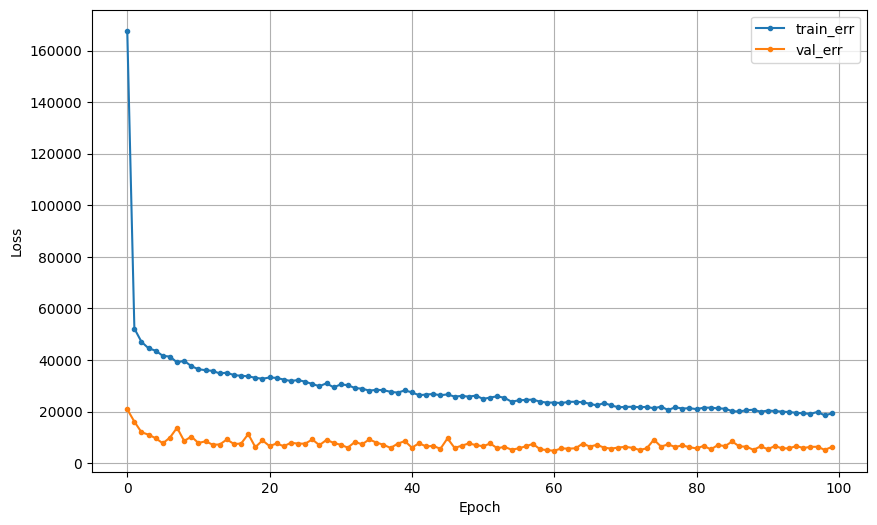

In [30]:
dl_history_plot(hist)

In [31]:
pred = model.predict(X_test_s)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')

RMSE : 70.70289189255601
MAE  : 54.542563414679165
MAPE : 1886268809472397.5
R2 : 0.9516721659815035


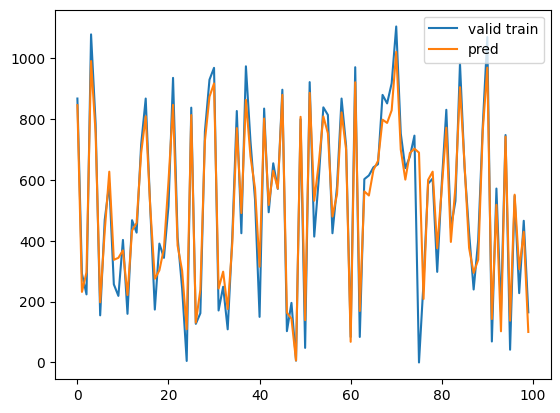

In [32]:
visualization_result(y_test_s,pred,size=100)

In [33]:
clear_session()
from tensorflow.keras.regularizers import l1, l2

model = Sequential([
    Dense(32, input_shape=(nfeatures,), activation='ELU', kernel_regularizer = l1(0.01)),
    Dense(16, input_shape=(32,), activation='ELU', kernel_regularizer = l1(0.01)),
    Dropout(0.5),
    Dense(1, input_shape=(16,), activation='ELU')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

hist = model.fit(X_train_s, y_train_s, epochs=100, validation_split=0.2, verbose=0).history

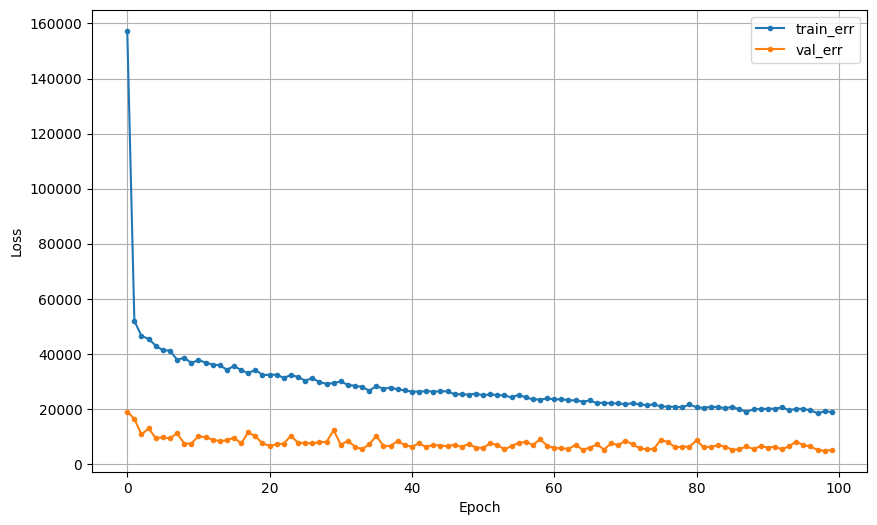

RMSE : 61.69550065151493
MAE  : 46.079332333534644
MAPE : 1827158615447511.2
R2 : 0.9632015131060703


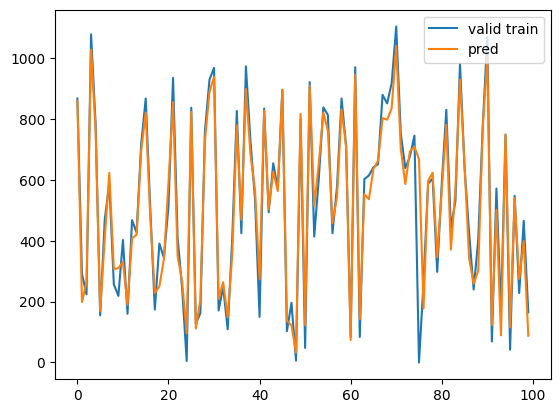

In [34]:
dl_history_plot(hist)

pred = model.predict(X_test_s)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')

visualization_result(y_test_s,pred,size=100)